In [1]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.base import BaseEstimator

%pylab inline

Populating the interactive namespace from numpy and matplotlib


В данной статье мы разберём простейшие алгоритмы рекомендательных систем.

Рекомендательные системы используются повсеместно:
1. Онлайн-кинотеатры используют их чтобы предлагать пользователям новые фильмы.
2. Социальные сети предлагают новых друзей или формируют ленту на основе ваших предпочтений.
3. Музыкальные сервисы, онлайн-радио подбирают музыку специально для вас.
4. Интернет-магазины предлагают товары пользователям, которые могут их заинтересовать.

Рассмотрим построение такой системы на датасете от `GroupLens` $-$ [`MovieLens`](https://grouplens.org/datasets/movielens/):
Это набор данных из $27 000$ фильмов и $138 000$ пользователей, с общим количеством оценок в $20$ миллионов.

Но мы воспользуемся уменьшенной версией для быстроты вычислений: $9 000$ фильмов, $700$ пользователей, $100 000$ оценок.
Скачать напрямую датасет можно по этой [ссылке](http://files.grouplens.org/datasets/movielens/ml-latest-small.zip)

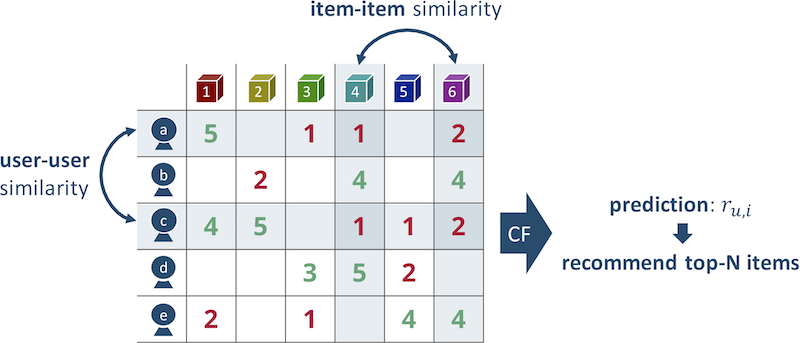

In [ ]:
# для UNIX систем
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

## Для начала немного посмотрим на данные
- `links.csv` $-$ связь между `id` фильма в датасете и `id` соответствующего фильма на `imdb.com` и `themoviedb.org`;
- `movies.csv` $-$ описание каждого фильма с его названием и жанрами;
- `ratings.csv` $-$ оценки пользователей фильмов с временной отметкой;
- `tags.csv` $-$ список тегов, которые поставил пользователь фильму, с временной отметкой.

Для данной задачи нам понадобятся только часть данных $-$ информация о том, какой рейтинг ставили пользователи фильмам.

In [2]:
ratings = pd.read_csv('./ml-latest-small/ratings.csv', parse_dates=['timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


### О метрике
Для рекомендательных систем используются стандартные метрики: `MSE`, `MAE` и `RMSE`.

Мы воспользуемся `RMSE`: классическая метрика для задач рекомендации после прошедшего [Netflix Prize](https://ru.wikipedia.org/wiki/Netflix_Prize). Хотя и у неё есть свои минусы, например:
- Ошибка в предсказании высокой оценки имеет такой же вес, что и ошибка в предсказании низкой оценки (предсказание 10 вместо 7 хуже, чем предсказать 4 вместо 1);
- Помимо предсказания рейтинга очень важно подать пользователю фильмы в нужном порядке, то есть необходимо учитывать и ранжирование, что данная метрика не умеет.

Так же сразу отложим часть выборки для тестирования модели по принципу: для каждого пользователя отрежем последние 20% оценок.

In [3]:
rmse = lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))

def train_test_split(X, ratio=0.2, user_col='userId', item_col='movieId',
                     rating_col='rating', time_col='timestamp'):
    # сортируем оценки по времени
    X.sort_values(by=[time_col], inplace=True)
    # список всех юзеров
    userIds = X[user_col].unique()
    X_train_data = []
    X_test_data = []
    y_train = []
    y_test = []
    for userId in tqdm_notebook(userIds):
        curUser = X[X[user_col] == userId]
        # определяем позицию, по которой делим выборку и размещаем данные по массивам
        idx = int(curUser.shape[0] * (1 - ratio))
        X_train_data.append(curUser[[user_col, item_col]].iloc[:idx, :].values)
        X_test_data.append(curUser[[user_col, item_col]].iloc[idx:, :].values)
        y_train.append(curUser[rating_col].values[:idx])
        y_test.append(curUser[rating_col].values[idx:])
    # cтекуем данные по каждому пользователю в общие массивы
    X_train = pd.DataFrame(np.vstack(X_train_data), columns=[user_col, item_col])
    X_test = pd.DataFrame(np.vstack(X_test_data), columns=[user_col, item_col])
    y_train = np.hstack(y_train)
    y_test = np.hstack(y_test)
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(ratings)

In [5]:
X_train.shape, len(y_train), X_test.shape, len(y_test)

((79748, 2), 79748, (20256, 2), 20256)

# Формализуем задачу
Имеется множество пользователей ($U$) и множество фильмов ($I$). Для некоторых фильмов конкретный пользователь уже поставил оценку ($r_{ui}$), надо предсказать оценку для определённых фильмов.

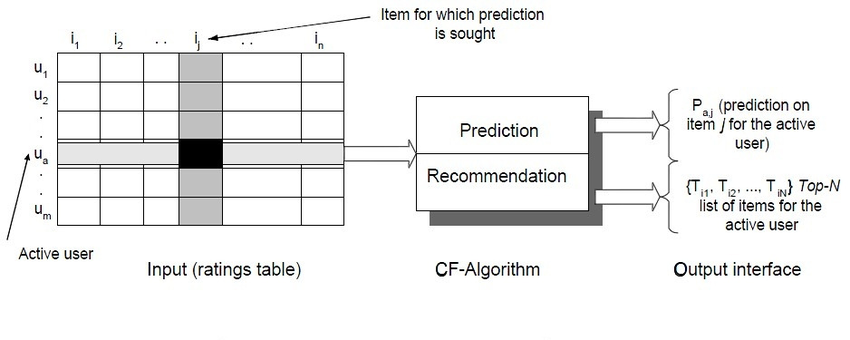

# User-based model

`user-based model` является моделью коллабораивной фильтрации, основная идея которой:
> похожим пользователям обычно нравятся похожие объекты

Определять схожесть $2$ пользователей будем с помощью корреляции Пирсона между векторами уже поставленными оценками, этот показатель хорош тем, что учитывает несколько важных ньюансов:
1. Два различных пользователя могут иметь мало общих фильмов, но при этом корреляция показывает большую схожесть, а иногда и вовсе $1$. Чтобы избежать этого давайте в числителе считать только общий рейтинг, а знаменатель оставим по всем рейтингам;
2. Для двух различных пользователей оценка может иметь различный вес, так для одного средний фильм имеет рейтинг $2$, а для другого $4$. Такие пользователи похожи, но корреляция скажет, что они различны. Чтобы устранить это, давайте из всех оценок пользователя вычтем его среднюю оценку.

Таким образом итоговая формула схожести двух пользователей вычисляется по формуле:
$$
    \textit{sim(u, v)} = \frac
    {\sum_i{\big((r_{ui} - \overline{r_u}) \times (r_{vi} - \overline{r_v})\big)}}
    {\sqrt{\sum_i{(r_{ui} - \overline{r_u})^2}} \times \sqrt{\sum_i{(r_{vi} - \overline{r_v})^2}}}
$$

Интуитивно понятно, что предпологаемый рейтинг для пользователя можно оценить как средний рейтинг между схожими пользователями, но, благодаря введению понятия схожести, можно улучшить эту оценку, ведя взвешенные веса и учитывая всех пользователей, которые посмотрели этот фильм:
$$
    r_{ui} = \overline{r_v} + \frac
    {\sum_{v \in User_i}\big(\textit{sim(u, v)} \times (r_{vi} - \overline{r_v})\big)}
    {\sum_{v \in User_i}\textit{sim(u, v)}}
$$

In [6]:
class UserBased(BaseEstimator):
    def fit(self, X, y, user_col='userId', item_col='movieId'):
        X = X.copy()
        # сохраним текущих пользователей и имеющиеся предметы
        self.users = X[user_col].unique()
        self.items = X[item_col].unique()
        
        X['y'] = y
        # рассчитаем среднее значение рейтинга для пользователя и предмета
        self.mean_y_user = X.groupby(user_col)['y'].mean()
        self.mean_y_item = X.groupby(item_col)['y'].mean()
        
        # вычитаем среднюю оценку пользователя
        X['y'] -= X[user_col].apply(lambda x: self.mean_y_user[x])
        
        # создаём векторы для каждого пользователя из просмотренных фильмов
        # для неизвестных фильмов ставим оценку 0
        self.user_ratings = pd.pivot_table(X, values='y', index=user_col,
                                           columns=item_col, fill_value=0)
        
        # считаем попарную схожесть между юзерами
        self.user_sim = cosine_similarity(self.user_ratings)
        
        # также сделаем словарь - {значение user_col: index в user_ratings}
        self.user_pos = dict()
        for user in self.users:
            self.user_pos[user] = np.argwhere(self.user_ratings.index.values == user)[0][0]
        return self
    
    def predict_rating(self, pr_user, pr_item):
        # если в обучающей выборке нет такого предмета
        # или пользователя, то вернём 0
        if not pr_item in self.items or not pr_user in self.users:
            return 0
        
        # считаем числитель и знаменатель дроби из формулы предсказания
        numerator = self.user_sim[self.user_pos[pr_user]].dot(
                        self.user_ratings.loc[:, pr_item])   
        # вычитаем 1, так как схожесть пользователя с самим собой равна 1,
        # но модель не должна это учитывать
        denominator = self.user_sim[self.user_pos[pr_user]].sum() - 1
        
        return self.mean_y_user[pr_user] + numerator / denominator
    
    def predict(self, X, user_col='userId', item_col='movieId'):
        y = X[[user_col, item_col]].apply(lambda row: self.predict_rating(row[0], row[1]), axis=1)
        return y

In [7]:
%%time
print('start fitting...')
ub = UserBased().fit(X_train, y_train)
print('start predicting...')
print('rmse = {}'.format(rmse(y_test, ub.predict(X_test))))

start fitting...
start predicting...
rmse = 7.629230983452234
CPU times: user 6.65 s, sys: 494 ms, total: 7.14 s
Wall time: 6.55 s


Как можно заметить, такой подход влечёт несколько проблем $-$ при увелечение количества предметов растёт сложность вычисления схожести, а значит и время работы, так же при большом количестве предметов данные получаются очень разреженные, поэтому пользователь даже не узнает про часть товара, хотя там могут быть и интересные ему.

# Item-based model
`item-based model` очень похожа на предыдущую модель по структуре, но теперь мы ищем похожие товары, а не пользователей.

Поэтому при вычисление $r_{ui}$ мы посмотрим на все фильмы пользователя $u$, оценим их схожесть с фильмом $i$ и посчитаем взвешенную сумму:
$$
    r_{ui} = \overline{r_i} + \frac
    {\sum_{j \in Item_u}\big(\textit{sim(i, j)} \times (r_{uj} - \overline{r_j})\big)}
    {\sum_{j \in Item_u}\textit{sim(i, j)}}
$$

Оценивать же схожесть двух фильмов будем с помощью той же корреляции Пирсона:
$$
    \textit{sim(i, j)} = \frac
    {\sum_u{\big((r_{ui} - \overline{r_i}) \times (r_{uj} - \overline{r_j})\big)}}
    {\sqrt{\sum_u{(r_{ui} - \overline{r_i})^2}} \times \sqrt{\sum_u{(r_{uj} - \overline{r_j})^2}}}
$$

In [8]:
class ItemBased(BaseEstimator):
    def fit(self, X, y, user_col='userId', item_col='movieId'):
        X = X.copy()
        # сохраним текущих пользователей и имеющиеся предметы
        self.users = X[user_col].unique()
        self.items = X[item_col].unique()
        
        X['y'] = y
        # рассчитаем среднее значение рейтинга для пользователя и предмета
        self.mean_y_user = X.groupby(user_col)['y'].mean()
        self.mean_y_item = X.groupby(item_col)['y'].mean()
        
        # вычитаем среднюю оценку предмета
        X['y'] -= X[item_col].apply(lambda x: self.mean_y_item[x])
        
        # создаём векторы для каждого фильма с оценками пользователя
        # если пользователь не поставил оценку, то ставим 0
        self.item_ratings = pd.pivot_table(X, values='y', index=item_col,
                                           columns=user_col, fill_value=0)
        
        # считаем попарную схожесть между фильмами
        self.item_sim = cosine_similarity(self.item_ratings)
        
        # также сделаем словарь {значение item_col: index в item_ratings}
        self.item_pos = dict()
        for item in self.items:
            self.item_pos[item] = np.argwhere(self.item_ratings.index.values == item)[0][0]
        return self
    
    def predict_rating(self, pr_user, pr_item):
        # если в обучающей выборке нет такого предмета
        # или пользователя, то вернём 0
        if not pr_item in self.items or not pr_user in self.users:
            return 0
        
        # считаем числитель и знаменатель дроби из формулы предсказания
        numerator = self.item_sim[self.item_pos[pr_item]].dot(
                        self.item_ratings.loc[:, pr_user])   
        # вычитаем 1, так как схожесть предмета с самим собой равна 1,
        # но модель не должна это учитывать
        denominator = self.item_sim[self.item_pos[pr_item]].sum() - 1
        
        return self.mean_y_item[pr_item] + numerator / denominator
    
    def predict(self, X, user_col='userId', item_col='movieId'):
        y = X[[user_col, item_col]].apply(lambda row: self.predict_rating(row[0], row[1]), axis=1)
        return y

In [9]:
%%time
print('start fitting...')
ib = ItemBased().fit(X_train, y_train)
print('start predicting...')
print('rmse = {}'.format(rmse(y_test, ib.predict(X_test))))

start fitting...
start predicting...
rmse = 1.8213743729065794
CPU times: user 8.05 s, sys: 791 ms, total: 8.84 s
Wall time: 6.02 s


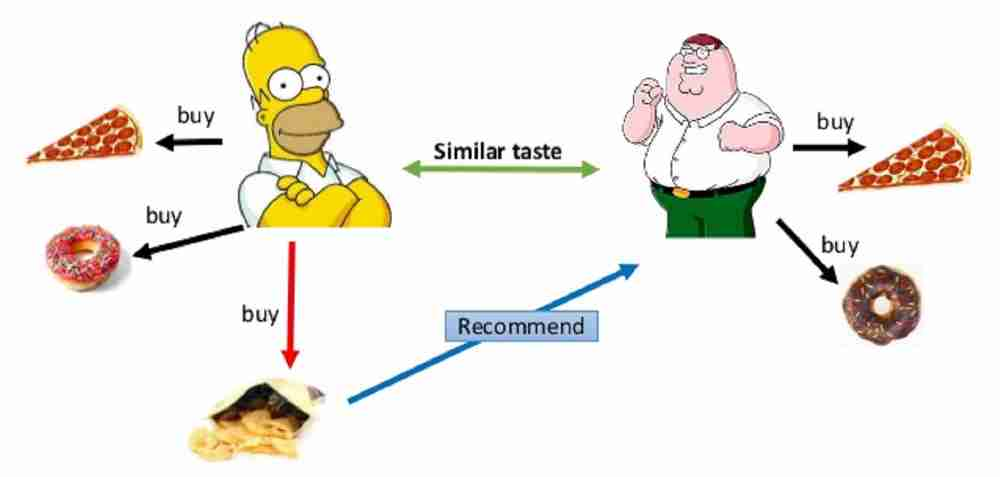

Как можно заметить данные алгоритмы имеют общие недостатки, например:
1. Холодный запуск, когда у нас нет информации о пользователе или товаре, то система не может предсказать рейтинг, мы возвращали в таких ситуациях 0, но, как вариант, можно возвращать среднюю оценку пользователя или среднюю оценку предмета, что уже даст хороший прирост в качестве.
2. Для нетипичных пользователей или предметов сложно дать объективные предсказания, так как они мало похожи на остальных.

Конечно это далеко не все алгоритмы построения рекомендательных систем, существуют более простые, один из них $-$ Most Popular, который просто возвращает наиболее популярные товары в сервисе, но которые пользователь ещё не видел, так и более сложные, например, SVD, который использует возможность сингулярного разложения матрицы пользователь-предмет, что позволяет выявлять какие-то скрытые параметры, например, как пол влияет на рейтинг и т.д.
Помимо коллаборативная фильтрации, существуют и другие принципы:
- Контентная фильтрация $-$ формирует рекомендацию на основе поведения пользователя, для решения подобных задач можно использовать, например, факторизационные машины;
- Смешанные подходы $-$ объединяют в себе content based и collaborative фильтрации.

Полезные ссылки:
- [Теоритическая статья от Яндекс](https://habrahabr.ru/company/yandex/blog/241455/);
- [Серия статей на medium, но код плохо оформлен](https://medium.com/@tomar.ankur287).